In [201]:
# https://www.kaggle.com/lodetomasi1995/income-classification
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.tree import export_graphviz
from IPython.display import Image
import pydotplus
from io import StringIO
from sklearn.model_selection import cross_val_score, ShuffleSplit, GridSearchCV, validation_curve, learning_curve
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
from pprint import pprint as pp
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
import time
from sklearn.preprocessing import LabelEncoder

In [202]:
import warnings; warnings.simplefilter('ignore')

In [208]:
np.random.seed(0)
df = pd.read_csv("../../Data/dataset2/train.csv")

df.dropna(inplace=True)
df.ffill(inplace=True)
df.bfill(inplace=True)
drop_indices = np.random.choice(np.arange(0, df.shape[0], 1), 350, replace=False)
df.drop(drop_indices, inplace=True)
X = df.drop(columns=['price_range'])
y = df[['price_range']]
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
df[['price_range']].value_counts()

price_range
1              419
0              417
2              416
3              398
dtype: int64

In [209]:
# preventing information about the distribution of the test set leaking into your model
standard_scaler = MinMaxScaler()
x_train_scaled = standard_scaler.fit_transform(x_train)
x_test_scaled = standard_scaler.fit_transform(x_test)
y_train_scaled = standard_scaler.fit_transform(y_train).astype('int')
y_test_scaled = standard_scaler.fit_transform(y_test).astype('int')

In [318]:
clf = KNeighborsClassifier(n_neighbors=1)
start_time = time.time()
clf.fit(x_train_scaled, y_train_scaled)
print(f"KNN Normal Model: Fit Time: {time.time() - start_time}")
start_time = time.time()
y_pred = clf.predict(x_test_scaled)
print(f"KNN Normal Model: Fit Time: {time.time() - start_time}")
print(f"Score of Model Tree are (Mean Accuracy of test and train data): {accuracy_score(y_test_scaled, y_pred)}")
print(classification_report(y_test_scaled, y_pred))

KNN Normal Model: Fit Time: 0.002596139907836914
KNN Normal Model: Fit Time: 0.013787984848022461
Score of Model Tree are (Mean Accuracy of test and train data): 0.7515151515151515
              precision    recall  f1-score   support

           0       0.84      0.84      0.84       254
           1       0.46      0.45      0.45        76

    accuracy                           0.75       330
   macro avg       0.65      0.64      0.65       330
weighted avg       0.75      0.75      0.75       330



In [319]:
d = df.shape[1]
depth_range = np.arange(1, 30, 1)
param = "n_neighbors"
classifier = "KNN"
train_scores, test_scores = validation_curve(clf, x_train, y_train, param_name=param, param_range=depth_range, cv=5, n_jobs=-1)

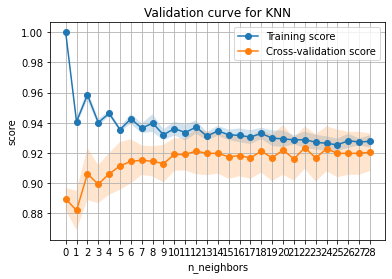

In [320]:
mean_train_scores = np.mean(train_scores, axis=1)
std_train_scores = np.std(train_scores, axis=1)
mean_test_scores = np.mean(test_scores, axis=1)
std_test_scores = np.std(test_scores, axis=1)
depth_range_list = np.arange(0, len(depth_range), 1)
plt.figure()
plt.xticks(np.arange(0, len(depth_range)))
plt.plot(depth_range_list, mean_train_scores, 'o-', label='Training score')
plt.fill_between(depth_range_list, mean_train_scores - std_train_scores, mean_train_scores + std_train_scores, alpha=0.2)
plt.plot(depth_range_list, mean_test_scores, 'o-', label='Cross-validation score')
plt.fill_between(depth_range_list, mean_test_scores - std_test_scores, mean_test_scores + std_test_scores, alpha=0.2)
plt.title(f'Validation curve for {classifier}')
plt.xlabel(param)
plt.ylabel("score")
plt.legend(loc="best")
plt.grid()
#plt.savefig(fig_path + 'dt_validation_curve_1.png')
plt.show()

In [230]:
### PIPELINES ###
# Data scaled in pipeline already
pipeline = Pipeline([('scaler', MinMaxScaler()),
                     ('sm1',SelectFromModel(RandomForestClassifier(),threshold='median')),
                     ('sm2',SelectFromModel(RandomForestClassifier(),threshold='median')),
                     ('knn', KNeighborsClassifier())])
pipeline.fit(x_train_scaled, y_train_scaled)
print(f"MLP Pipeline Model: Fit Time: {time.time() - start_time}")
start_time = time.time()
y_pred_pipeline = pipeline.predict(x_test_scaled)
print(f"MLP Pipeline Model: Predict Time: {time.time() - start_time}")
print(classification_report(y_test_scaled, y_pred_pipeline))

MLP Pipeline Model: Fit Time: 79.19746589660645
MLP Pipeline Model: Predict Time: 0.01737356185913086
              precision    recall  f1-score   support

           0       0.97      0.96      0.96       254
           1       0.86      0.91      0.88        76

    accuracy                           0.95       330
   macro avg       0.92      0.93      0.92       330
weighted avg       0.95      0.95      0.95       330



In [254]:
### TUNING ####
d = x_train.shape[1]
param = {'knn__n_neighbors': np.arange(1, 50, 1), 
         'knn__weights':['uniform','distance'],
         'knn__metric':['manhattan','euclidean','chebyshev']
        }
clf_cv = GridSearchCV(pipeline, n_jobs=-1, param_grid=param, refit=True, cv=5, return_train_score=True, verbose=1)
start_time = time.time()
clf_cv = clf_cv.fit(x_train_scaled, np.ravel(y_train_scaled))
print(f"MLP CV Model: Fit Time: {time.time() - start_time}")
start_time = time.time()
y_pred_pipeline_cv = clf_cv.predict(x_test_scaled)
print(f"MLP CV Model: Predict Time: {time.time() - start_time}")
print(f"Score of Model Tree are (Mean Accuracy of test and train data): {accuracy_score(y_test_scaled, y_pred_pipeline_cv)}")
print(classification_report(np.ravel(y_test_scaled), y_pred_pipeline_cv))

Fitting 5 folds for each of 294 candidates, totalling 1470 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 96 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 259 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done 609 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done 1059 tasks      | elapsed:    9.9s
[Parallel(n_jobs=-1)]: Done 1470 out of 1470 | elapsed:   12.4s finished


MLP CV Model: Fit Time: 12.75483775138855
MLP CV Model: Predict Time: 0.0135955810546875
Score of Model Tree are (Mean Accuracy of test and train data): 0.9515151515151515
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       254
           1       0.89      0.89      0.89        76

    accuracy                           0.95       330
   macro avg       0.93      0.93      0.93       330
weighted avg       0.95      0.95      0.95       330



In [255]:
clf_cv.best_params_

{'knn__metric': 'euclidean',
 'knn__n_neighbors': 18,
 'knn__weights': 'distance'}

In [312]:
train_sizes = np.arange(0.1, 1.0, 0.1)
clf_new = KNeighborsClassifier(metric="euclidean", n_neighbors=18, weights='distance')
_, train_scores, test_scores = learning_curve(clf_new, x_train, np.ravel(y_train), train_sizes=train_sizes, cv=5)

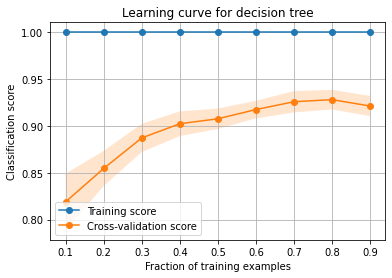

In [313]:
plt.figure()
mean_train_scores = np.mean(train_scores, axis=1)
std_train_scores = np.std(train_scores, axis=1)
mean_test_scores = np.mean(test_scores, axis=1)
std_test_scores = np.std(test_scores, axis=1)
plt.plot(train_sizes, mean_train_scores, 'o-', label='Training score')
plt.fill_between(train_sizes, mean_train_scores - std_train_scores, mean_train_scores + std_train_scores, alpha=0.2)
plt.plot(train_sizes, mean_test_scores, 'o-', label='Cross-validation score')
plt.fill_between(train_sizes, mean_test_scores - std_test_scores, mean_test_scores + std_test_scores, alpha=0.2)
plt.title('Learning curve for decision tree')
plt.xlabel('Fraction of training examples')
plt.ylabel("Classification score")
plt.legend(loc="best")
plt.grid()
#plt.savefig(fig_path + 'dt_learning_curve.png')
plt.show()

In [296]:
lw = 2
neighbors = np.arange(1, 50, 1)
clf_score_list = []
fit_time_list = []
predict_time_list = []
main_start_time = time.time()
for i in neighbors:
    clf = KNeighborsClassifier(n_neighbors=i, metric='euclidean', weights='distance')
    start_time = time.time()
    clf.fit(x_train_scaled, y_train_scaled)
    clf_score_list.append(clf.score(x_test_scaled, y_test_scaled))
    
    end_time = time.time() - start_time
    fit_time_list.append(end_time)
    
    start_time = time.time()
    y_pred = clf.predict(x_test_scaled)
    end_time = time.time() - start_time
    predict_time_list.append(end_time)
    
print(f"Entire cell took {time.time() - main_start_time}")

Entire cell took 1.2954931259155273


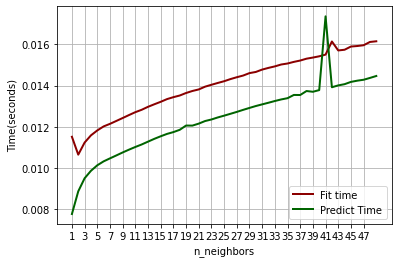

In [297]:
def normalize_data_points(points):
    return points
    return [float(i)/sum(points) for i in points]

lw = 2
param_list = np.arange(1, 50, 1)
# param_list = np.arange(0, len([(h,)*l for l in [1,2,3,4,5] for h in [d,d//2,d*2]]))
plt.plot(param_list, normalize_data_points(fit_time_list), label="Fit time", color="darkred", lw=lw)
plt.plot(param_list, normalize_data_points(predict_time_list), label="Predict Time", color="darkgreen", lw=lw)

plt.xlabel('n_neighbors')
plt.ylabel("Time(seconds)")
plt.xticks(np.arange(1, len(param_list), 2.0))
# plt.yticks(np.arange(min(predict_time_list), max(fit_time_list), 0.004))
plt.grid()
plt.legend(loc='lower right')

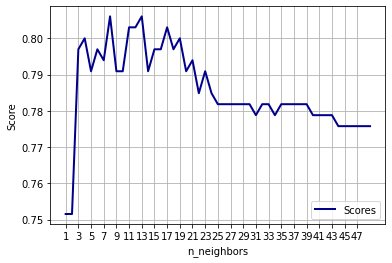

In [298]:
lw = 2
param_list = np.arange(1, 50, 1)
plt.plot(param_list, clf_score_list, label="Scores", color="darkblue", lw=lw)
plt.xlabel('n_neighbors')
plt.ylabel("Score")
plt.xticks(np.arange(1, len(param_list), 2.0))
plt.grid()
plt.legend(loc='lower right')